In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace

In [2]:
import os
import pickle
import argparse
import numpy as np
import pandas as pd
from pathlib import Path
import time
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from reacher_def import RotReacherEnv
import utils

def custom_mean(df):
    return df.mean(skipna=False)

def custom_std(df):
    return df.std(skipna=False)

In [7]:
### Use this in order to fuse several .pkl files in one folder into one
utils.fuse_dataframes('analysis/models_test')
data_raw = pd.read_pickle('analysis/models_test.pkl')

### make all trials the same lengths
all_modes = data_raw['mode'].unique()
all_units = data_raw['# LSTM units'].unique()
all_trials = data_raw['trial'].unique()
all_timepoints = data_raw['timepoint'].unique()
all_experiments = data_raw['experiment'].unique()

names = ["mode", "# LSTM units",'experiment', "trial", 'timepoint']
mind = pd.MultiIndex.from_product(
    [all_modes, all_units, all_experiments, all_trials, all_timepoints], names=names)
data_raw = data_raw.set_index(names).reindex(mind).reset_index()

### add column with the penalties
error_fun = lambda row: np.linalg.norm(np.array([row.loc['x (cm)'], row.loc['y (cm)']]) - np.array([8,0]))
data_raw = data_raw.assign(**{'penalty (cm)': data_raw.apply(error_fun, axis=1)})

data_raw.to_pickle('analysis/models_test.pkl')

Reading files in analysis/models_test ...
Finished. Saved fused file models_test in analysis.


In [46]:
### For playing around
data_raw = pd.read_pickle('analysis/models_test.pkl')
data_raw['mode'].unique()

array(['rotplus', 'original', 'rot'], dtype=object)

In [47]:
def plot_cumulative_error(filename=None, save_dir=None):
    if filename is None:
        filename = 'models_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    ### prepare data to plot cumulative error
    data_cum_error = data_raw.groupby(['mode', '# LSTM units', 'experiment', 'trial'])[["error (cm)"]].sum()
    data_cum_error = data_cum_error.reset_index()
    data_cum_error.rename(columns={'error (cm)':'cumulative error (cm)'}, inplace=True)
    data_cum_error['mode'] = data_cum_error['mode'].map({'original': 'Original', 
                                                         'rot': 'Rot', 
                                                         'rotplus': 'Rot+'})
    g = sns.relplot(x='trial', 
                    y='cumulative error (cm)', 
                    hue='mode', 
                    hue_order=['Rot', 'Rot+', 'Original'],
                    col='# LSTM units', 
                    height=5, 
                    kind='line', 
                    err_style='bars',
                    data=data_cum_error)
    
    #plt.tight_layout()
    return g.fig

def plot_cumulative_penalty(filename=None, save_dir=None):
    if filename is None:
        filename = 'models_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    ### prepare data to plot cumulative error
    data_cum_pen = data_raw.groupby(['mode', '# LSTM units', 'experiment', 'trial'])[["penalty (cm)"]].sum()
    data_cum_pen = data_cum_pen.reset_index()
    data_cum_pen.rename(columns={'penalty (cm)':'cumulative penalty (cm)'}, inplace=True)
    data_cum_pen['mode'] = data_cum_pen['mode'].map({'original': 'Original', 
                                                         'rot': 'Rot', 
                                                         'rotplus': 'Rot+'})
    g = sns.relplot(x='trial', 
                    y='cumulative penalty (cm)', 
                    hue='mode', 
                    hue_order=['Rot', 'Rot+', 'Original'],
                    col='# LSTM units', 
                    height=5, 
                    kind='line', 
                    err_style='bars',
                    data=data_cum_pen)
    
    #plt.tight_layout()
    return g.fig

def plot_angular_error(filename=None, save_dir=None):
    if filename is None:
        filename = 'models_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return    
    
    ### prepare data to plot angular error after 200 ms (timepoint = 3)
    data_angle_error = data_raw
    data_angle_error['mode'] = data_raw['mode'].map({'original': 'Original', 
                                                     'rot': 'Rot', 
                                                     'rotplus': 'Rot+'})
    data_angle_error = data_angle_error.loc[data_angle_error['timepoint']==3]
    
    g = sns.relplot(x='trial', 
                    y='angular error (rad)', 
                    hue='mode', 
                    hue_order=['Rot', 'Rot+', 'Original'],
                    col='# LSTM units', 
                    height=5, 
                    kind='line', 
                    err_style='bars',
                    data=data_angle_error)
    
    #plt.tight_layout()
    return g.fig

def plot_trajectories(filename=None, save_dir=None):
    if filename is None:
        filename = 'models_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    data_raw['mode'] = data_raw['mode'].map({'original': 'Original', 
                                             'rot': 'Rot', 
                                             'rotplus': 'Rot+'})
    
    lstm_units = sorted(data_raw['# LSTM units'].unique())
    color_palette = sns.color_palette()
    fig , axs = plt.subplots(1, len(lstm_units), sharex=True, sharey=True, figsize=(20, 5))
    
    for idx, ax in enumerate(axs):
        data_loop = data_raw.loc[(data_raw['# LSTM units']==lstm_units[idx])]
        data_first = data_loop.loc[data_loop['trial']==1]
        data_first_traj = data_first.groupby(['mode', 'timepoint']).agg({'x (cm)': custom_mean, 'y (cm)': custom_mean}).reset_index()
        ### trajectories in first trial (dashed)
        g = sns.lineplot(x="x (cm)", y="y (cm)", hue="mode", hue_order=['Rot', 'Rot+', 'Original'], 
                         ax=ax, data=data_first_traj)
        for line in ax.lines:
            line.set_linestyle("--")
        
        ### standard deviation ellipses in first trial        
        means = data_first_traj.dropna()
        means = means.loc[means.groupby(['mode'])['timepoint'].idxmax()][['x (cm)', 'y (cm)']].values
        stds = data_first.groupby(['mode', 'timepoint']).agg({'x (cm)': custom_std, 'y (cm)': custom_std}).reset_index().dropna()
        stds = stds.loc[stds.groupby(['mode'])['timepoint'].idxmax()][['x (cm)', 'y (cm)']].values
        custom_order = [1,2,0]
        for k in range(means.shape[0]):
            end_point = matplotlib.patches.Ellipse(means[custom_order[k]], stds[custom_order[k],0], stds[custom_order[k],1], 
                                                   edgecolor=color_palette[k], facecolor=color_palette[k], alpha=0.3)
            ax.add_artist(end_point)

        ### plot average trajectories for all other trials
        data_rest = data_loop.loc[data_loop['trial']>1]
        data_rest_traj = data_rest.groupby(['mode', 'trial', 'timepoint']).agg({'x (cm)': custom_mean, 'y (cm)': custom_mean}).reset_index()
        g = sns.lineplot(x="x (cm)", y="y (cm)", hue="mode", hue_order=['Rot', 'Rot+', 'Original'], 
                         style='trial', dashes=False, ax=ax, data=data_rest_traj)
        
        ### add goal region
        goal_reg = plt.Circle([8, 0], 1.6, edgecolor='k', fill=False, linewidth=4, alpha=0.5)
        ax.add_artist(goal_reg)
        ax.set_aspect('equal')
        ax.set_title('# LSTM units = {}'.format(lstm_units[idx]))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ### make legend
        if idx+1 != len(axs):
            ax.get_legend().remove()
        else:
            leg = ax.get_legend()
            lines = leg.get_lines()
            new_lines = list(lines[i] for i in [1,5,2,6,3,7])
            new_labels = ['Rot trial 1', 'Rot subsequent trials', 
                          'Rot+ trial 1', 'Rot+ subsequent trials', 
                          'Original trial 1', 'Original subsequent trials']
            ax.legend(new_lines, new_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
            
    plt.tight_layout()
    #axs[0].set_xlim([0, 10])
    #axs[0].set_ylim([-3, 3])
    
    return fig

def make_reproduction_plot(filename=None, save_dir=None):
    if filename is None:
        filename = 'models_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    ### slice only lstm = 100 and modes = 'Rot' & 'Rot+'
    data_raw['mode'] = data_raw['mode'].map({'original': 'Original', 
                                             'rot': 'Rot', 
                                             'rotplus': 'Rot+'})
    data_raw = data_raw.loc[(data_raw['mode']!='Original') & (data_raw['# LSTM units']==100)]
    lstm_units = sorted(data_raw['# LSTM units'].unique())
    color_palette = sns.color_palette()
    fig , axs = plt.subplots(2, 2, figsize=(20, 10))
    
    ### UPPER LEFT: trajectories
    ax = axs[0,0]
    data_first = data_raw.loc[data_raw['trial']==1]
    data_first_traj = data_first.groupby(['mode', 'timepoint']).agg({'x (cm)': custom_mean, 'y (cm)': custom_mean}).reset_index()
    ### trajectories in first trial (dashed)
    g = sns.lineplot(x="x (cm)", y="y (cm)", hue="mode", hue_order=['Rot','Rot+'], 
                     ax=ax, data=data_first_traj)
    for line in ax.lines:
        line.set_linestyle("--")
        
    means = data_first_traj.dropna()
    means = means.loc[means.groupby(['mode'])['timepoint'].idxmax()][['x (cm)', 'y (cm)']].values
    stds = data_first.groupby(['mode', 'timepoint']).agg({'x (cm)': custom_std, 'y (cm)': custom_std}).reset_index().dropna()
    stds = stds.loc[stds.groupby(['mode'])['timepoint'].idxmax()][['x (cm)', 'y (cm)']].values
    for k in range(means.shape[0]):
        end_point = matplotlib.patches.Ellipse(means[k], stds[k,0], stds[k,1], 
                                               edgecolor=color_palette[k], facecolor=color_palette[k], alpha=0.3)
        ax.add_artist(end_point)

    ### plot average trajectories for all other trials
    data_rest = data_raw.loc[data_raw['trial']>1]
    data_rest_traj = data_rest.groupby(['mode', 'trial', 'timepoint']).agg({'x (cm)': custom_mean, 'y (cm)': custom_mean}).reset_index()
    g = sns.lineplot(x="x (cm)", y="y (cm)", hue="mode", hue_order=['Rot','Rot+'], 
                     style='trial', dashes=False, ax=ax, data=data_rest_traj)

    ### add goal region
    goal_reg = plt.Circle([8, 0], 1.6, edgecolor='k', fill=False, linewidth=4, alpha=0.5)
    ax.add_artist(goal_reg)
    ax.set_aspect('equal')
    ax.set_title('Trajectories')
    ax.set_xlim([0, 10])
    ax.set_ylim([-3, 3])

    ### make legend
    leg = ax.get_legend()
    lines = leg.get_lines()
    new_lines = list(lines[i] for i in [1,4,2,5])
    new_labels = ['Rot trial 1', 'Rot subs. trials', 
                  'Rot+ trial 1', 'Rot+ subs. trials']
    ax.legend(new_lines, new_labels, loc='upper left', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ### UPPER RIGHT: cumulative penalty
    ax = axs[0,1]
    data_cum_pen = data_raw.groupby(['mode', '# LSTM units', 'experiment', 'trial'])[["penalty (cm)"]].sum()
    data_cum_pen = data_cum_pen.reset_index()
    data_cum_pen.rename(columns={'penalty (cm)':'cumulative penalty (cm)'}, inplace=True)
    g = sns.lineplot(x='trial', y='cumulative penalty (cm)', hue='mode', 
                    hue_order=['Rot', 'Rot+'], err_style='bars', ax=ax,
                    data=data_cum_pen)
    ax.set_title('Cumulative penalty')
    ax.legend(loc='upper right', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ### BOTTOM LEFT: velocities
    ax = axs[1,0]
    data_vel = data_raw.assign(**{'velocity (cm/s)': data_raw.apply(lambda row: np.linalg.norm(row.loc['vel_x (cm/s)']-row.loc['vel_y (cm/s)']), axis=1)})
    g = sns.lineplot(x='trial', y='velocity (cm/s)', hue='mode', 
                    hue_order=['Rot', 'Rot+'], err_style='bars', ax=ax,
                    data=data_vel)
    ax.set_title('Average velocity')
    ax.legend(loc='upper right', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ### BOTTOM RIGHT: angular error
    ax = axs[1,1]
    data_angle_error = data_raw.loc[data_raw['timepoint']==3]
    g = sns.lineplot(x='trial', y='angular error (rad)', hue='mode', 
                     hue_order=['Rot', 'Rot+'], err_style='bars', ax=ax,
                     data=data_angle_error)
    ax.set_title('Angular error after 200 ms')
    ax.legend(loc='upper right', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    
    return fig

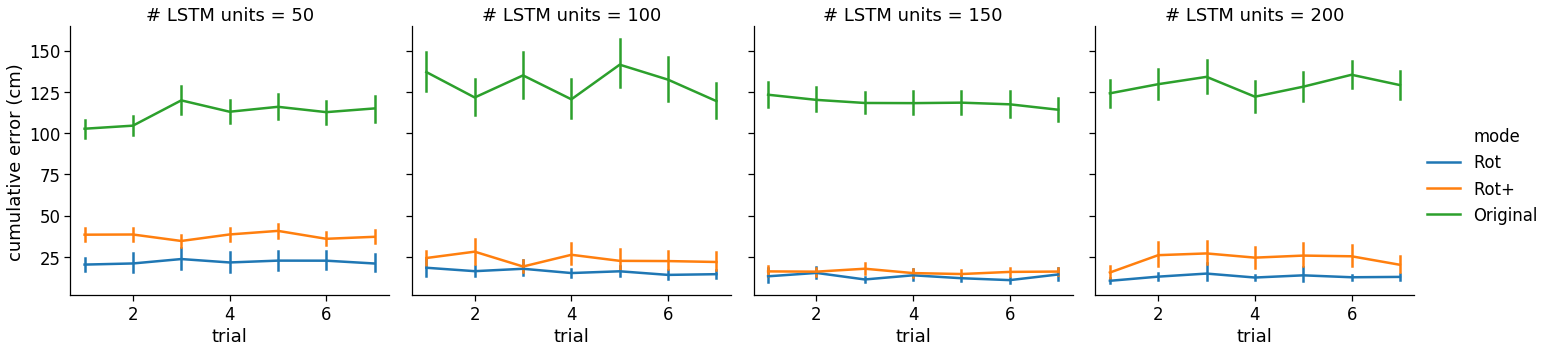

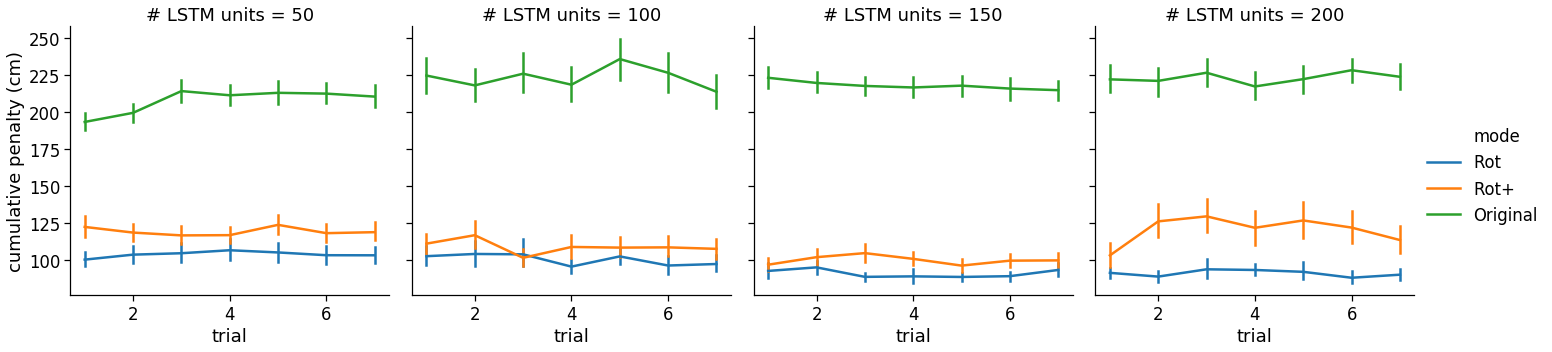

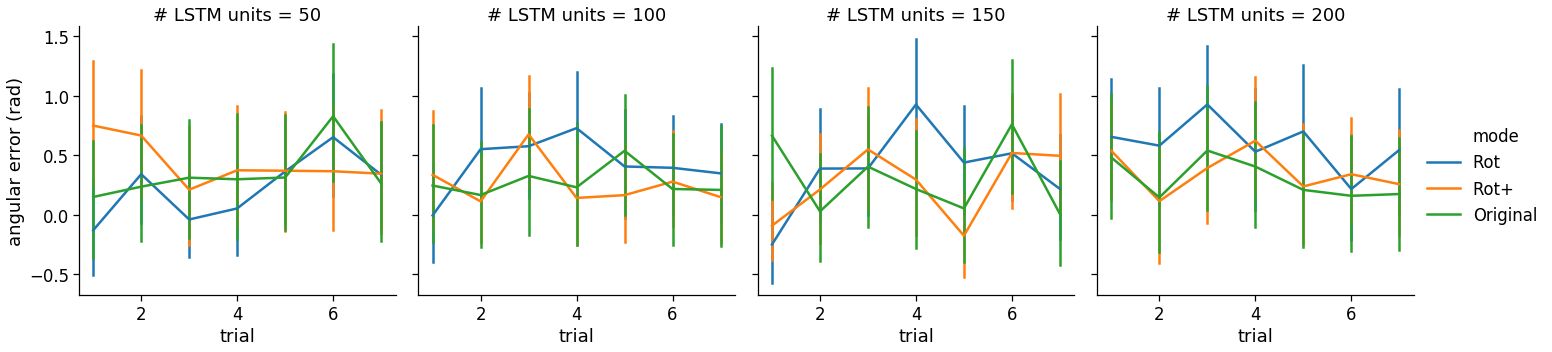

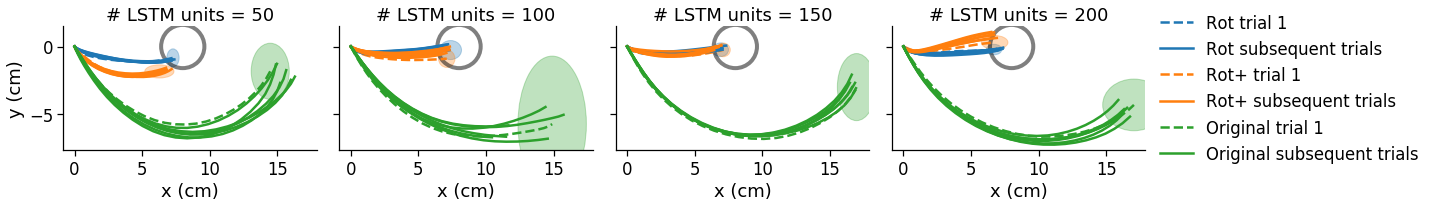

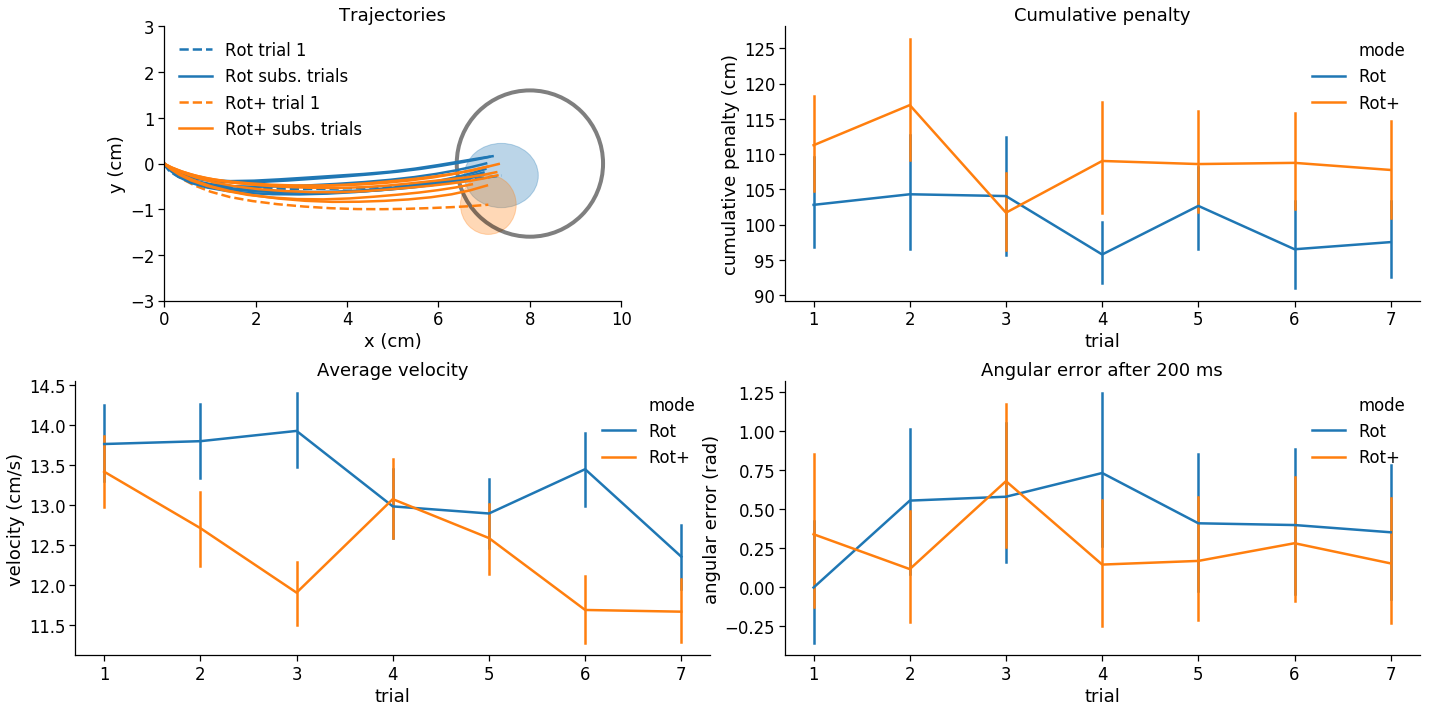

In [48]:
fig_cum_error = plot_cumulative_error()
fig_cum_pen = plot_cumulative_penalty()
fig_ang_error = plot_angular_error()
fig_traj = plot_trajectories()
fig_reproduction = make_reproduction_plot()

In [49]:
fig_cum_error.savefig('figures/models_cum_error.pdf', format='pdf')
fig_cum_error.savefig('figures/models_cum_error.eps', format='eps')
fig_cum_pen.savefig('figures/models_pen_error.pdf', format='pdf')
fig_cum_pen.savefig('figures/models_pen_error.eps', format='eps')
fig_ang_error.savefig('figures/models_ang_error.pdf', format='pdf')
fig_ang_error.savefig('figures/models_ang_error.eps', format='eps')
fig_traj.savefig('figures/models_traj.pdf', format='pdf')
fig_traj.savefig('figures/models_traj.eps', format='eps')
fig_reproduction.savefig('figures/models_reproduction.pdf', format='pdf')
fig_reproduction.savefig('figures/models_reproduction.eps', format='eps')